# Clasificación: Wine Dataset

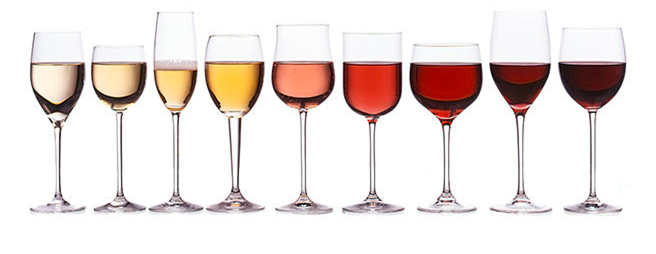

Qué vamos a hacer?

* Cargar el dataset.
* Transformar el atributo ``quality`` en categórico para poder hacer clasificación.
* Clasificar!

In [ ]:
import pandas as pd

Vamos a trabajar nuevamente con el dataset de vinos.
Tenemos varias opciones (excluyentes):

1. Trabajamos solo con el dataset de vinos tintos.

In [ ]:
df_wines = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv", delimiter=";")

2. Trabajamos solo con el dataset de vinos blancos.

In [ ]:
df_wines = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv", delimiter=";")

3. Mergeamos ambos datasets en uno.

In [ ]:
df_red = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv", delimiter=";")
df_white = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv", delimiter=";")
df_wines = pd.concat([df_red, df_white])

In [ ]:
df_wines

Una vez elegido el dataset, seguimos con el procesamiento. En este caso, sabemos que el dataset no contiene valores nulos, pero si puede haber duplicados, con lo que solo vamos a eliminar filas duplicadas.

In [ ]:
df_wines = df_wines.drop_duplicates()
df_wines

Dado que vamos a estar trabajando con un problema de clasificación, necesitamos convertir la columna ``quality`` numérica en una columna categórica.

Para esto, necesitamos definir una serie de reglas:


$quality\text{_}label=\begin{cases}
low & if\,value\leq5\\
medium & if\,5<value\leq7\\
high & if\,value>7
\end{cases}$

Las vamos a aplicar usando la función ``apply`` para chequear el valor usado en la columna ``quality``. 

Nota. El resultado de aplicar la función es una serie, para evitar warnings de asignación de Pandas, la transformamos primero en una lista.

In [ ]:
df_wines['quality_label'] = df_wines['quality'].apply(lambda value: 'low' if value <= 5 else 'medium' if value <= 7 else 'high').tolist()
df_wines['quality_label'] = pd.Categorical(df_wines['quality_label'], categories=['low', 'medium', 'high'])

In [ ]:
df_wines.info()

In [ ]:
df_wines['quality_label'].value_counts() # tenemos un dataset bastante desbalanceado

Vamos a ver las estadísticas agrupadas de las diferentes categorías.

1. Agrupamos las filas/instancias utilizando las columnas ``alcohol``, ``density``, ``pH`` y ``quality``.
2. Usamos el ``describe`` para ver las estadísticas descriptivas de cada grupo. 
3. Concatenamos los outpus para cada uno de los grupos.

In [ ]:
subset_attr = ['alcohol', 'density', 'pH', 'quality'] # 1

low = round(df_wines[df_wines['quality_label'] == 'low'][subset_attr].describe(), 2) # 2
medium = round(df_wines[df_wines['quality_label'] == 'medium'][subset_attr].describe(), 2) # 2
high = round(df_wines[df_wines['quality_label'] == 'high'][subset_attr].describe(), 2) # 2

pd.concat([low, medium, high], axis=1, #3
          keys=['Low Quality Wine', 
                'Medium Quality Wine', 
                'High Quality Wine'])

Ahora, vamos a clasificar!

Vamos a probar algunos modelos.

* Logistic regression
* Support vector machine
* K-nearest neighbor classifier
* Random forest classifier
* Decision tree classifier
* Gradient boosting classifier
* Gaussian Naive Bayes classifier

Cargamos las bibliotecas que vamos a necesitar.

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC,SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier,
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

In [ ]:
from sklearn.model_selection import train_test_split,cross_validate
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score

La variable categórica la vamos a transformar en numérica para que pueda ser entendida por los modelos.

In [ ]:
label_quality = LabelEncoder()

df_wines['quality_label'] = label_quality.fit_transform(df_wines['quality_label'])

In [ ]:
df_wines.tail(10)

También vamos a borrar la columna de ``quality`` que es la que originalmente utilizamos para construir nuestra variable target.

In [ ]:
df_wines = df_wines.drop(['quality'],axis=1)

df_wines

Hay diferentes formas de dividir los datos para entrenar y evaluar modelos. Las principales son:

* **Training/test**. El conjunto de datos se divide en dos partes disjuntas, una para el entrenamiento y otra para la evaluación. También puede incluir un conjunto de validación que es utilizado para evaluar el modelo entrenado, en caso de que haya tuneo de hiper parámetros.

* **Crossvalidation**. Si tenemos pocos datos, realizar una única división en training/test puede hacer que se pierda información relevante para el modelo a entrenar, pudiendo causar *under fitting*. En este caso, los datos son divididos en $k$ subcojuntos y el análisis de traning/test es repetido $k$ veces, de forma tal que en cada vez, uno de los $k$ subconjuntos es utilizado como conjunto de testing y los $k-1$ restantes como training. De esta forma, cada instancia es utilizada una vez como validación y $k-1$ veces como training, lo que permite reducir el bias y la varianza. Luego, las estadísticas finales son obtenidas promediando los resultados obtenidos por los diferentes modelos entrenados. Valores típicos de $k$ son 5 y 10.

En este caso, vamos a arrancar con una división simple en training/test, donde vamos a utilizar el 30% de los datos para testing. La opción de ``stratify`` indica que en las porciones de training y test se mantengan las mismas proporciones de instancias por clases que en los datos originales.

Nota. Definimos ``random_state=42`` para poder obtener particiones reproducibles en distintas ejecuciones.

In [ ]:
x_train,x_test,y_train,y_test =  \
        train_test_split(df_wines.drop(['quality_label'],axis=1), df_wines['quality_label'], \
                         stratify=df_wines['quality_label'], test_size=0.30, random_state=42)

In [ ]:
x_train

Definimos los modelos que vamos a utilizar.

In [ ]:
models= {'LogisticRegression': LogisticRegression(max_iter=500), # el cambio de iteraciones es para intentar que converga, puede que aún no lo haga
        'LinearSVM': LinearSVC(),
        'rbfSVM': SVC(kernel='rbf'),
        'KNearestNeighbors': KNeighborsClassifier(),
        'RandomForestClassifier': RandomForestClassifier(),
        'DecisionTree': DecisionTreeClassifier(),
        'GradientBoostingClassifier': GradientBoostingClassifier(),
        'GaussianNB': GaussianNB()}        

También tenemos que decidir qué [métricas](https://scikit-learn.org/stable/modules/model_evaluation.html) vamos a utilizar para evaluar los modelos. Las más utilizadas son:

| Métrica | Definición | Cuánto utilizarla? | Desventajas |
|---|---|---|---|
| Accuracy | Cantidad de predicciones correctas por sobre el total de predicciones. | Datasets balanceados. | Por su desbalance natural,  dará buenos resultados en datasets con un marcado desbalance, pero los resultados no serán útiles. |
| Precision | Qué proporción de los predichos como positivo fueron realmente positivos. | Se quiere estar "muy seguro" de que las predicciones son correctas. | Ajustar por precisión va a hacer que estemos muy seguros que lo que estamos prediciendo está bien, pero muy posiblemente se haya muchos falsos negativos. |
| Recall | Qué proporción de los realmente positivos fueron predichos como positivos. | Es más importante encontrar todos los correctos, antes que acertar todas las predicciones. | Ajustar por recall va a conducir, probablemente a subir la cantidad de falsos positivos. |
| F-measure | Media armónica de la precisión y el recall. | Tanto precisión como recall son importantes. | Por defecto, da el mismo peso a la precisión y al recall. Se puede adaptar. |

Estas definiciones corresponden a casos binarios, donde solo se tiene la clase positiva y la clase negativa. En los escenarios multi-clase, es precisio realizar una adaptación que resuma las métricas. Existen varias alternativas:

* *Micro Average*. Toma en cuenta las salidas globales, independientemente de a qué clase pertenecen. Las instancias son verdaderas cuando la clase predicha coincide con la original y falsas cuando la predicción no coincide con la clase. Útil cuando se tienen clases desbalanceadas y no es importante controlar los errores para una clase particular.

* *Macro Average*. Se calculan las métricas binarias para cada clase, lo que resultará en tantos valores como clases se tengan. El valor final se calculará como el promedio de los valores obtenidos para cada una de las clases. En el promedio, el resultado de todas las clases tendrá el mismo peso, independientemente de su cantidad de instancias. De esta forma, aún siendo insensible al tamaño de cada clase, sube la importancia relativa de las clases más pequeñas. 

* *Weighted Average*. Al igual que en la versión macro, se calculan las métricas binarias para cada clase. Luego, se realiza el promedio ponderado de los valores, ajustando su importancia de acuerdo al tamaño de la clase en consideración.

Para más detalles, se puede ver ["Metrics for Multi-class Classification: An Overview"](https://arxiv.org/pdf/2008.05756.pdf).

In [ ]:
from tqdm.notebook import tqdm
from collections import defaultdict

metrics = defaultdict(dict)

for name,classification_model in tqdm(models.items()):
    classification_model.fit(x_train,y_train) # hacemos el entrenamiento del modelo
    pred = classification_model.predict(x_test) # una vez entrenado predecimos la clase de las instancias de test
    
    metrics['accuracy'][name] = accuracy_score(pred,y_test)
    
    metrics['precision_weighted'][name] = precision_score(pred,y_test,average='weighted')
    metrics['recall_weighted'][name] = recall_score(pred,y_test,average='weighted')
    metrics['fmeasure_weighted'][name] = f1_score(pred,y_test,average='weighted')
    
    metrics['precision_micro'][name] = precision_score(pred,y_test,average='micro')
    metrics['recall_micro'][name] = recall_score(pred,y_test,average='micro')
    metrics['fmeasure_micro'][name] = f1_score(pred,y_test,average='micro')
    
    metrics['precision_macro'][name] = precision_score(pred,y_test,average='macro')
    metrics['recall_macro'][name] = recall_score(pred,y_test,average='macro')
    metrics['fmeasure_macro'][name] = f1_score(pred,y_test,average='macro')

In [ ]:
metrics_table = pd.DataFrame(metrics)
metrics_table = metrics_table.sort_values(by='accuracy', ascending=[False])
metrics_table

Hasta acá hicimos una clasificación siguiendo un procesamiento simple... qué más podríamos hacer?

1. El dataset tiene columnas numéricas que no están en los mismos rangos e incluso puede haber valores que sean outliers. Podríamos aplicar algún tipo de normalización a las columnas. Por ejemplo, usando algunos de los [scalers](https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html) ya disponibles en sklearn.

2. El dataset se encuentra desbalanceado, ya que tiene muchas instancias para las clases ``medium`` y ``low``, pero muy pocas para la clase ``high``. Podríamos aplicar algún tipo de estrategia de sampling para balancear el dataset.

3. Hay una cantidad relativamente pequeña de instancias, quizás sea preferible adoptar un esquema de cross-validation.

4. Los modelos fueron entrenados con sus parámetros pre-definidos, se podría realizar una optimización de sus hiper-parámetros.